# Entity Resolution- Dedupe Model

In [13]:
# Import Statements
from __future__ import print_function
from future.builtins import next

import os
import csv
import re
import collections
import numpy

import dedupe
from unidecode import unidecode

Setup

In [14]:
# the output_file will store the results of the record linkage deduplication
output_file = 'data_matching_output.csv'

# the settings file will contain the data model and predicates that determine matches
settings_file = 'data_matching_learned_settings'

# the training_file will contain the pairs of labeled examples that the model was trained on
training_file = 'data_matching_training.json'


In [15]:
# method to clean the data using Unidecode and Regex

def preProcess(column):
    # convert any unicode data into ASCII characters
    column = unidecode(column)
    # ignore new lines
    column = re.sub('\n', ' ', column)
    # ignore special characters
    column = re.sub('-', '', column)
    column = re.sub('/', ' ', column)
    column = re.sub("'", '', column)
    column = re.sub(",", '', column)
    column = re.sub(":", ' ', column)
    # ignore extra white space
    column = re.sub('  +', ' ', column)
    # ignore casing
    column = column.strip().strip('"').strip("'").lower().strip()
    if not column :
        column = None
    return column


In [16]:
# Read the data from the CSV and create a dictionary of addresses

def readData(filename):
    
    # initialize the dictionary
    data_d = {}

    # read each row in the CSV, clean the data, and it to a dictionary
    with open(filename) as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            clean_row = dict([(k, preProcess(v)) for (k, v) in row.items()])
            # each address will have a unique ID consisting of the file name and a unique number
            data_d[filename + str(i)] = dict(clean_row)

    return data_d

In [17]:
# Import the data
data_1 = readData('new_companies.csv')
data_2 = readData('new_companies_users.csv')

Train the model

In [18]:
# if there already exists a settings_file (with the data model),
# create a Dedupe object (linker) that will load the saved settings
if os.path.exists(settings_file):
    print('reading from', settings_file)
    with open(settings_file, 'rb') as sf :
        # create a record link object for saved settings- pass the data model to it
        linker = dedupe.StaticRecordLink(sf)

# if there is no previously saved settings data, create it
else:
    # Define the fields the linker will pay attention to
    # Specifying fields refines the comparison methods so not each part of the record are compared equally
    # for example, dedupe will learn which of these fields have higher weights (more important in determining matches) by using regularized logistic regression
    # String types compared using affine gap string distance
    # Note- the address field is only for US addresses (uses usaddress package to split into components)
        # must have dedupe-variable-address installed to use this
    fields = [
        {'field' : 'CompanyName', 'type': 'String'},
        {'field' : 'Full_Address', 'type': 'String'},]
    
    # Create a new linker object
    linker = dedupe.RecordLink(fields)
    # To train the linker, feed it a sample of records.
    linker.sample(data_1, data_2, 15000)

    
    # If we have training data saved from a previous run of linker,
    # look for it and load it in.
    if os.path.exists(training_file):
        print('reading labeled examples from ', training_file)
        with open(training_file) as tf :
            linker.readTraining(tf)

    # ## Active learning
    # Dedupe will find the next pair of records
    # it is least certain about and ask for them to be labelled as matches
    # or not.
    print('starting active labeling...')

    # Label examples, add them to the training data, and update the mathcing model
    dedupe.consoleLabel(linker)

    linker.train()

    # When finished, save training data as labeled examples in the training_file
    with open(training_file, 'w') as tf :
        linker.writeTraining(tf)

    # Save weights and predicates.  If the settings file
    # exists, skip all the training and learning next time we run
    # this file.
    with open(settings_file, 'wb') as sf :
        linker.writeSettings(sf)

INFO:dedupe.api:((SimplePredicate: (sortedAcronym, Full_Address), TfidfNGramSearchPredicate: (0.6, CompanyName)), (SimplePredicate: (commonThreeTokens, CompanyName), TfidfTextSearchPredicate: (0.4, Full_Address)), (SimplePredicate: (firstIntegerPredicate, CompanyName), TfidfNGramSearchPredicate: (0.6, Full_Address)))


reading from data_matching_learned_settings


Blocking

In [19]:
import itertools

# Split the data up into groups of records with some feature in common
# Only comparing the entries in these blocks reduces number of comparisons
# This is more useful with larger datasets- where we would use a representative sample rather than all the data
# 2 blocking methods- predicate blocks and index (using inverted index)
blocks = linker._blockData(data_1,data_2)

Calculate precision, recall, threshold

In [20]:
# the records will be duplicates
candidate_records = itertools.chain.from_iterable(linker._blockedPairs(blocks))

# Calculate the probability that pair of records are duplicates
probability = dedupe.core.scoreDuplicates(candidate_records,
                                           linker.data_model,
                                           linker.classifier,
                                           linker.num_cores)['score']

probability = probability.copy()
probability.sort()
probability = probability[::-1]

expected_dupes = numpy.cumsum(probability)

# Recall- TP/(TP + FN) - ability to find all interesting data points
recall = expected_dupes / expected_dupes[-1]
# Precision- TP/(TP + FP) - take the probability that the pairs are duplicates divided by the total number of duplicates
precision = expected_dupes / numpy.arange(1, len(expected_dupes) + 1)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records


In [21]:
print("probability:", probability)
print("expected duplicates:", expected_dupes)
print("recall:",recall)
print("precision:",precision)

probability: [0.96879673 0.96879673 0.96879673 0.96202236 0.9612511  0.94986814
 0.9401054  0.93533444 0.92907256 0.9132344  0.9129198  0.9129198
 0.90678036 0.88700145 0.8788225  0.8554713  0.8476454  0.83515435
 0.8046382  0.7958472  0.77570057 0.7610263  0.69086343 0.68097645
 0.6603313  0.54154974 0.44843125 0.44843125 0.36229447 0.301954
 0.21531999 0.14224826 0.13657743 0.11743887 0.08842647 0.07917296
 0.06073797 0.03264759]
expected duplicates: [ 0.96879673  1.9375935   2.9063902   3.8684125   4.8296638   5.779532
  6.7196374   7.654972    8.584044    9.497279   10.410199   11.323119
 12.229899   13.1169     13.995723   14.851194   15.69884    16.533995
 17.338633   18.13448    18.91018    19.671206   20.362068   21.043045
 21.703377   22.244926   22.693357   23.141788   23.504084   23.806038
 24.021358   24.163607   24.300184   24.417624   24.50605    24.585222
 24.64596    24.678608  ]
recall: [0.03925654 0.07851308 0.11776961 0.15675165 0.19570243 0.23419197
 0.2722859  0.31

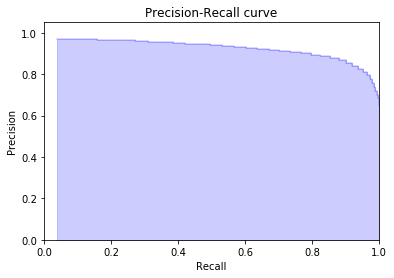

In [22]:
# Display the predicted precision-recall plot

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


plt.step(recall, precision, color='b', alpha=.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

# PR curve looks nearly perfect due to small amounts of data

Clustering

In [23]:
# Find the threshold that will maximize a weighted average of our
# precision and recall (F Score) for a sample of data.  When we set the recall weight to 2, we are
# saying we care twice as much about recall as we do precision.
#
# The weighted avg, or F-score = 2tp/(2tp + fp + fn)
# 
# In this case, set the recall_weight to .5- saying we care twice as much about precision
# as we do recall. When matching the data, set the threshold closer to 1 to raise precision
# 
# This is called hierarchical clustering with centroid linkage
# Example- A is related to B, C is related to B, so those would all be clustered with B as centroid
# The threshold determines the minimum probability for a record to be related to the centroid

recall_weight = .9

score = recall * precision / (recall + recall_weight ** 2 * precision)

i = numpy.argmax(score)

print('Maximum expected recall and precision')
print('recall: %2.3f', recall[i])
print('precision: %2.3f', precision[i])
print('With threshold: %2.3f', probability[i])

calcThreshold= probability[i]

print("Threshold to maximize expected F score =", calcThreshold )


print('clustering...')
linked_records = linker.match(data_1, data_2, threshold=calcThreshold)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records


Maximum expected recall and precision
recall: %2.3f 0.90138495
precision: %2.3f 0.8555740943321815
With threshold: %2.3f 0.54154974
Threshold to maximize expected F score = 0.54154974
clustering...


In [24]:
print('# duplicate sets', len(linked_records))

# duplicate sets 9


Write results

In [25]:
# Write our original data back out to a CSV with a new column called 
# 'Cluster ID' which indicates which records refer to each other.

cluster_membership = {}
cluster_id = None
for cluster_id, (cluster, score) in enumerate(linked_records):
    for record_id in cluster:
        cluster_membership[record_id] = (cluster_id, score)

if cluster_id :
    unique_id = cluster_id + 1
else :
    unique_id =0

In [26]:
with open(output_file, 'w') as f:
    writer = csv.writer(f)
    
    header_unwritten = True

    for fileno, filename in enumerate(('company_addresses.csv', 'company_addresses_users.csv')) :
        with open(filename) as f_input :
            reader = csv.reader(f_input)

            if header_unwritten :
                heading_row = next(reader)
                heading_row.insert(0, 'source file')
                heading_row.insert(0, 'Link Score')
                heading_row.insert(0, 'Cluster ID')
                writer.writerow(heading_row)
                header_unwritten = False
            else :
                next(reader)

            for row_id, row in enumerate(reader):
                cluster_details = cluster_membership.get(filename + str(row_id))
                if cluster_details is None :
                    cluster_id = unique_id
                    unique_id += 1
                    score = None
                else :
                    cluster_id, score = cluster_details
                row.insert(0, fileno)
                row.insert(0, score)
                row.insert(0, cluster_id)
                writer.writerow(row)

In [27]:
name = input('Enter the company name: ')
addr = input('Enter the address: ')
# state = input('Enter the state: ')
# zip_code = input('Enter the zip code: ')

# create a new file that will contain the user's entry
user_input_file = 'user_input_file.csv'
with open (user_input_file, 'w', newline='') as csvfile:
    fieldnames = ['id', 'CompanyName', 'Full_Address']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({'id' : "1", 'CompanyName':name, 'Full_Address': addr})
csvfile.close()

#AB TECHSYS LTD 	 INTERNATIONAL HOUSE 24 HOLBORN VIADUCT LONDON EC1A 2BN

Enter the company name: 
Enter the address: 


In [28]:
data_entry = readData('user_input_file.csv')

In [29]:
# now, need to update the settings file and training file when user enters a new address

In [30]:
match = linker.match(data_1, data_entry)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records


BlockingError: No records have been blocked together. Is the data you are trying to match like the data you trained on?

In [31]:
# import pickle
# pickle.dump(readData, open("read_data_obj", 'wb'))

In [32]:
# x = pickle.load(open("read_data_obj",'rb'))

In [33]:
# x("company_addresses.csv")

In [34]:
# x = linker.match(data_1, data_entry)

In [35]:
id = int(data_1[match[0][0][0]]['id'])

NameError: name 'match' is not defined

In [36]:
with open('new_companies.csv', 'r') as my_file:
    reader = csv.reader(my_file)
    rows = list(reader)
    print (rows[id][1] + " " + rows[id][2])

TypeError: list indices must be integers or slices, not builtin_function_or_method